<a href="https://colab.research.google.com/github/lupis30puc/BERT_interpretation_with_RF/blob/main/preprocessing_for_bert_yelp_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Yelp dataset on kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset)

On this notebook I obtain a sample of 12k reviews from the original Yelp dataset. 

For analysis purposes I simplify the starts rating into two labels: 0 ( negative) and 1 (positive). 

The sample dataset contains the review text, the label, the reviews' business categories, the cleaned version of the reviews and the reviews' length.

These are the noteboooks I take as reference to process the Yelp dataset: [Sentiment analysis with Yelp and BERT](https://signal.onepointltd.com/post/102gc83/sentiment-analysis-with-yelp-and-bert), [Gil Mendez's repository](https://github.com/onepointconsulting/yelp_bert/blob/master/preprocess_data.ipynb), [Sentiment Analysis on Yelp reviews](https://github.com/Sonull/Sentiment-Analysis-on-Yelp-Reviews/blob/master/RF_and_SVM1.ipynb)



## Connecting with Kaggle for the dataset

In [ ]:
# as the dataset is very big (around 4GB), it's btter to connect to kaggle a pull the necessary sample only
import json

with open('kaggle.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

# show values
print("username: " + str(obj['username']))
print("key: " + str(obj['key']))


In [ ]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username": "angelapuc", "key": "59d8152009b75546f66c636d8b551bee"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library


In [ ]:
!kaggle datasets download -d {'yelp-dataset/yelp-dataset'} -p /content/kaggle/

In [ ]:
!apt install unzip

In [ ]:
!unzip  /content/kaggle/yelp-dataset.zip -d /content/kaggle/yelp-dataset

## Obtaining a sample of the reviews

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.model_selection import train_test_split

In [ ]:
review_file = '/content/kaggle/yelp-dataset/yelp_academic_dataset_review.json'

In [ ]:
sample_size = 40000 # First we get a pre-liminary sample that we will balance afterwards
simplified_reviews = './yelp_reviews_simple_{sample_size}.json'

def extract_simplified(source, target, lines=1000):
    with open(target, 'w') as sr:
        cnt = 0;
        with open(source) as file:
            line = file.readline()
            while line:
                cnt += 1
                if cnt == lines:
                    break
                if cnt % 100_000 == 0:
                    print(f'Processed {cnt}')
                try:
                    line = file.readline().strip()
                    review_dict = json.loads(line)
                    # we define the columns we want to collect
                    simplified = {'text':  review_dict['text'], 'stars': review_dict['stars'], 'business_id': review_dict['business_id']}
                    simplified_text = json.dumps(simplified)
                    sr.write(f'{simplified_text}\n')
                except:
                    print(f'Could not parse {line}')
                    
extract_simplified(review_file, simplified_reviews, lines=sample_size)

In [ ]:
simplified_reviews_pd = pd.read_json(simplified_reviews, lines=True)
simplified_reviews_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         39999 non-null  object
 1   stars        39999 non-null  int64 
 2   business_id  39999 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [ ]:
simplified_reviews_pd.shape

(39999, 3)

In [ ]:
simplified_reviews_pd.head()

,text,stars,business_id
0,I am actually horrified this place is still in...,1,lbrU8StCq3yDfr-QMnGrmQ
1,I love Deagan's. I do. I really do. The atmosp...,5,HQl28KMwrEKHqhFrrDqVNQ
2,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1,5JxlZaqCnk1MnbgRirs40Q
3,"Oh happy day, finally have a Canes near my cas...",4,IS4cv902ykd8wj1TR0N3-A
4,This is definitely my favorite fast food sub s...,5,nlxHRv1zXGT0c0K51q3jDg


## Balancing the dataset and obtaining only 2 labels

In [ ]:
simplified_reviews_pd['stars'].value_counts()

5    17495
4     9218
1     5593
3     4445
2     3248
Name: stars, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


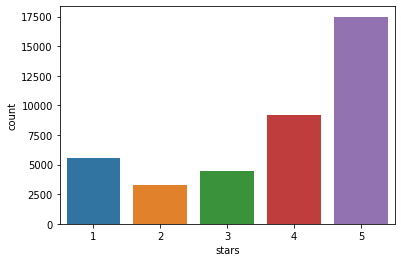

In [ ]:
sns.countplot(simplified_reviews_pd['stars'])

In [ ]:
# we initialize a Counter fucntion to determine which is the min count in the star ratings
counter_star = Counter(simplified_reviews_pd['stars'])

In [ ]:
min_class = -1
min_amount = 1000000000
for cs in counter_star:
    if min_amount > counter_star[cs]:
        min_amount = counter_star[cs]
        min_class = cs
min_class, min_amount

(2, 3248)

In [ ]:
# we then define how much reviews are we going to delete to balance the sample
remove_amounts = {c: abs(min_amount - counter_star[c]) for c in counter_star}
remove_amounts

{1: 2345, 2: 0, 3: 1197, 4: 5970, 5: 14247}

In [ ]:
remove_amounts[1] -= 1
remove_amounts

{1: 2344, 2: 0, 3: 1197, 4: 5970, 5: 14247}

In [ ]:
%%time
drop_indices = []
for index, row in simplified_reviews_pd.iterrows():
    if remove_amounts[row['stars']] > 0:
        remove_amounts[row['stars']] -= 1
        drop_indices.append(index)
len(drop_indices)

CPU times: user 3.43 s, sys: 560 µs, total: 3.43 s
Wall time: 3.46 s


In [ ]:
balanced_simplified_reviews = simplified_reviews_pd.drop(drop_indices)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


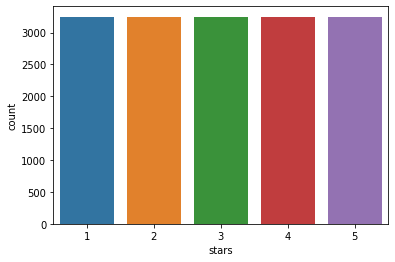

In [ ]:
# the distribution is balanced now
sns.countplot(balanced_simplified_reviews['stars'])

In [ ]:
balanced_simplified_reviews['stars'].unique()

array([2, 3, 1, 4, 5])

In [ ]:
# dropping reviews with 3 stars
balanced_simplified_reviews.drop(balanced_simplified_reviews.index[balanced_simplified_reviews['stars'] == 3], inplace = True)
print('yelp_reviews labels: ' + str(balanced_simplified_reviews.stars.unique()))
print('yelp_reviews shape: ' + str(balanced_simplified_reviews.shape))


yelp_reviews labels: [2 1 4 5]
yelp_reviews shape: (12993, 3)


In [ ]:
# changing to only 2 labels: 0=negative, 1=positive
balanced_simplified_reviews['label'] = balanced_simplified_reviews['stars'].replace({1:0,2:0,4:1,5:1})
balanced_simplified_reviews['stars'].value_counts()

1    3249
5    3248
4    3248
2    3248
Name: stars, dtype: int64

In [ ]:
balanced_simplified_reviews.drop('stars',inplace=True,axis = 1)
balanced_simplified_reviews.head(2)

,text,business_id,label
31,This actually used to be one of my favorite ho...,LkMtMHVetws5_7QfRjPtlg,0
62,Decent food. Fishermen lobster or even congee ...,eNFubUPJR7yIQah-NxZN_g,0


In [ ]:
balanced_simplified_reviews.shape

## Getting the business categories for each review

In [ ]:
# since the business file is not that big, we obtain it in a differet way
import time
def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [ ]:
%%time
print('loading business data...')
business_df = read_json('/content/kaggle/yelp-dataset/yelp_academic_dataset_business.json')

loading business data...
CPU times: user 3.79 s, sys: 414 ms, total: 4.2 s
Wall time: 4.22 s


In [ ]:
business_df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None


In [ ]:
# on the whole dataset there are more than 100k categories
len(business_df.categories.unique())

102495

In [ ]:
business_df.categories.unique()[:10]

array(['Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping',
       'Health & Medical, Fitness & Instruction, Yoga, Active Life, Pilates',
       'Pets, Pet Services, Pet Groomers',
       'Hardware Stores, Home Services, Building Supplies, Home & Garden, Shopping',
       'Home Services, Plumbing, Electricians, Handyman, Contractors',
       'Auto Repair, Automotive, Oil Change Stations, Transmission Repair',
       'Dry Cleaning & Laundry, Local Services, Laundry Services',
       'Auto Repair, Oil Change Stations, Automotive, Tires',
       'Ethnic Food, Food Trucks, Specialty Food, Imported Food, Argentine, Food, Restaurants, Empanadas',
       'Martial Arts, Gyms, Fitness & Instruction, Active Life'],
      dtype=object)

In [ ]:
# we then merge the data frames so we obtain the categories for each review
categories_id = business_df[['business_id','categories']]
balanced_reviews = balanced_simplified_reviews.merge(categories_id, how='left', on='business_id')
balanced_reviews.head()

,text,business_id,label,categories
0,This actually used to be one of my favorite ho...,LkMtMHVetws5_7QfRjPtlg,0,"Casinos, Nightlife, Restaurants, Hotels & Trav..."
1,Decent food. Fishermen lobster or even congee ...,eNFubUPJR7yIQah-NxZN_g,0,"Seafood, Restaurants, Food, Chinese, Seafood M..."
2,"Pros: Fun atmosphere, great for people watchin...",l_kefVF1frmC0xRW2YkvUA,0,"Nightlife, Bars, American (Traditional), Music..."
3,"I love bookstores, and I love to spend some ti...",V2TN04eMwKJmGki8ioOY9A,0,"Shopping, Bookstores, Books, Mags, Music & Video"
4,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",vQMcpsCYhkpJKvkity2VHA,0,"Burgers, Restaurants, Salad, Sandwiches"


In [ ]:
# on our sample there are 4000 unique categories
print(balanced_reviews.shape)
print(len(balanced_reviews.categories.unique()))

(12993, 4)
4000


In [ ]:
# checking only the first 10 unique categories
balanced_reviews.categories.unique()[:10]

array(['Casinos, Nightlife, Restaurants, Hotels & Travel, Tennis, Active Life, Steakhouses, Event Planning & Services, Music Venues, Sushi Bars, Arts & Entertainment, Food, Japanese, Hotels',
       'Seafood, Restaurants, Food, Chinese, Seafood Markets, Specialty Food, Dim Sum, Japanese',
       'Nightlife, Bars, American (Traditional), Music Venues, Dance Clubs, Restaurants, Arts & Entertainment, Beer, Wine & Spirits, Cocktail Bars, Lounges, Food, Event Planning & Services, Sports Bars, Venues & Event Spaces',
       'Shopping, Bookstores, Books, Mags, Music & Video',
       'Burgers, Restaurants, Salad, Sandwiches',
       'Restaurants, Asian Fusion, Japanese, Bars, Sushi Bars, Nightlife',
       'Pet Groomers, Pet Services, Pets',
       'Japanese, Sushi Bars, Restaurants', 'Hotels & Travel, Airports',
       'Nightlife, Dance Clubs'], dtype=object)

In [ ]:
# there are some NaN, that we drop out
balanced_reviews[balanced_reviews.categories.isna() == True]

,text,business_id,label,categories
2410,"*Okay, this is strictly based on their ""10,000...",aUluscKiuPmd8L2K7-FvyA,0,None
4744,Houses The Light Factory and McGlohn Theater. ...,1rgJ-WYCEWM-RIyQN6AteA,1,None
5985,My friend tried so hard to work with this guy....,3stT022u8m1H37mcopGuUA,0,None
8442,STAY CLEAR! Canmax sales reps promise a great...,eefO7_-EYi7f4V9RwckKgg,0,None


In [ ]:
balanced_reviews.dropna(inplace=True)

In [ ]:
# O is negative, 1 is positive
balanced_reviews.label.value_counts()

0    6497
1    6496
Name: label, dtype: int64

In [ ]:
balanced_reviews.reset_index(drop=True, inplace=True)
balanced_reviews.head(2)

,text,business_id,label
0,This actually used to be one of my favorite ho...,LkMtMHVetws5_7QfRjPtlg,0
1,Decent food. Fishermen lobster or even congee ...,eNFubUPJR7yIQah-NxZN_g,0


## Cleaning the reviews

In [ ]:
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from nltk.corpus import stopwords
import re

In [ ]:
# As we want to interpret BERT results we want to focus on the words than in other sentence components
for r in balanced_reviews:
    balanced_reviews['clean_text'] = balanced_reviews['text'].apply(lambda t: re.sub(r"https?://[A-Za-z0-9./]+", ' ', t))
    balanced_reviews['clean_text'] = balanced_reviews['clean_text'].apply(lambda t: re.sub(r"[^a-zA-Z]", ' ', t))
    balanced_reviews['clean_text'] = balanced_reviews['clean_text'].apply(lambda t: strip_multiple_whitespaces(t))
    balanced_reviews['clean_text'] = balanced_reviews['clean_text'].apply(lambda t: t.lower())
    balanced_reviews['clean_text'] = balanced_reviews['clean_text'].apply(lambda t: remove_stopwords(t))
    balanced_reviews['clean_text'] = balanced_reviews['clean_text'].apply(lambda t: strip_short(t))

In [ ]:
balanced_reviews.head()

,text,business_id,label,categories,clean_text
0,This actually used to be one of my favorite ho...,LkMtMHVetws5_7QfRjPtlg,0,"Casinos, Nightlife, Restaurants, Hotels & Trav...",actually favorite hotel casinos day things cha...
1,Decent food. Fishermen lobster or even congee ...,eNFubUPJR7yIQah-NxZN_g,0,"Seafood, Restaurants, Food, Chinese, Seafood M...",decent food fishermen lobster congee queen bet...
2,"Pros: Fun atmosphere, great for people watchin...",l_kefVF1frmC0xRW2YkvUA,0,"Nightlife, Bars, American (Traditional), Music...",pros fun atmosphere great people watching mech...
3,"I love bookstores, and I love to spend some ti...",V2TN04eMwKJmGki8ioOY9A,0,"Shopping, Bookstores, Books, Mags, Music & Video",love bookstores love spend time browsing flipp...
4,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",vQMcpsCYhkpJKvkity2VHA,0,"Burgers, Restaurants, Salad, Sandwiches",passed guys carl sonic habit won happen know s...


## Adding length column to remove more noise

In [ ]:
# before cleaning
balanced_simplified_reviews['length'] = balanced_simplified_reviews['text'].apply(lambda x : len(x.strip().split(" ")))
balanced_simplified_reviews['length'].describe()

count    12993.000000
mean       116.033172
std        106.976797
min          1.000000
25%         46.000000
50%         82.000000
75%        149.000000
max       1340.000000
Name: length, dtype: float64

In [ ]:
# after cleaning
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
balanced_reviews['length'] = balanced_reviews['clean_text'].apply(lambda x : len(x.strip().split(" ")))
balanced_reviews['length'].describe()

count    12993.000000
mean        47.718464
std         42.064071
min          1.000000
25%         20.000000
50%         34.000000
75%         61.000000
max        396.000000
Name: length, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


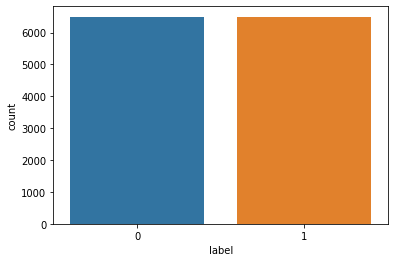

In [ ]:
# Checking the label distribbution
sns.countplot(balanced_reviews['label'])

CPU times: user 317 ms, sys: 133 ms, total: 450 ms
Wall time: 317 ms


<Figure size 1800x1440 with 0 Axes>

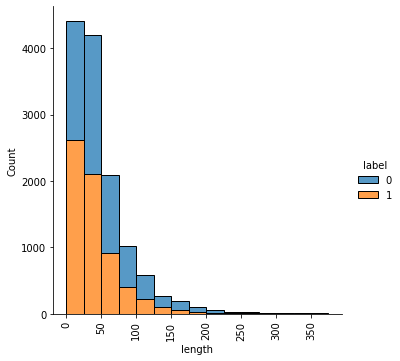

In [ ]:
%%time 
# checking the sample reviews' length distribution per label
plt.figure(figsize=(25, 20))
plot = sns.displot(data=balanced_reviews, x='length', hue='label', multiple='stack', bins=np.arange(0,400,25))
plt.xticks(rotation=90)

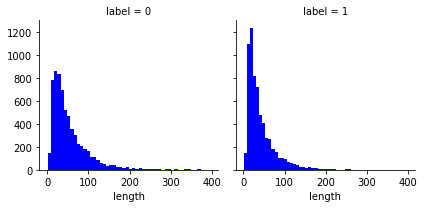

In [ ]:
# COMPARING TEXT LENGTH TO LABELS
# on the cleaned reviews
graph = sns.FacetGrid(data=balanced_reviews,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')
# 0 negative, 1 positive

In [ ]:
# checking the reviews with very small lengths
balanced_reviews[['text', 'clean_text', 'length']][balanced_reviews['length']<=4].sort_values(by='length')

,text,clean_text,length
3841,タイ料理屋さん。\n夕食分と朝食分を持ち帰りで注文。自分、日本人なんだけど、辛さはどのくらい...,,1
6497,如果做创新餐厅要丢掉传统菜的口味和优点，那还是不要创新了。天妇罗互相之间粘在一起，鳗鱼卷两个...,,1
10936,:),,1
3021,Fancy Buca di Beppo,fancy buca beppo,3
9523,Its Starbucks\nGreat Parking,starbucks great parking,3
10981,soup filled dumplings.,soup filled dumplings,3
2972,this place sucks....food is horrible.,place sucks food horrible,4
6264,Bring back the prairie grain salad!!!,bring prairie grain salad,4
7459,Hair chopped on one side; not cut on the other...,hair chopped cut won,4
7913,Surprisingly casual and terrific food.,surprisingly casual terrific food,4


In [ ]:
#checking the 95% quantile from all the sample
np.quantile(balanced_reviews['length'], 0.95)

128.0

In [ ]:
#checking the 90% quantile from all the sample
np.quantile(balanced_reviews['length'], 0.90)

99.0

In [ ]:
#checking the top largest reviews
balanced_reviews[['text', 'clean_text', 'length']][balanced_reviews['length']>128].sort_values(by='length')

,text,clean_text,length
5136,I'm a huge Bobby Flay fan so couldn't wait to ...,huge bobby flay fan couldn wait try mesa grill...,129
578,"Came here with my husband, BFF, and her boyfri...",came husband bff boyfriend crowded wait minute...,129
3474,"Fervente de la cuisine vietnamienne, j'avais ...",fervente cuisine vietnamienne avais remarqu no...,129
6982,Lack's Cleaning is the best carpet/floor clean...,lack cleaning best carpet floor cleaning compa...,129
6172,"The only reason I'm giving this place a 4, is ...",reason giving place kinda wait little served c...,129
...,...,...,...
1722,"The movie, ""Casino"", is an appropriate metapho...",movie casino appropriate metaphorical type exp...,366
4925,Very disappointing! My family and I visited a ...,disappointing family visited large number deal...,371
6393,Let me preface this with 1. I'm a Hilton Hono...,let preface hilton honors member timeshare pre...,374
2194,I wish I could say something amazing about thi...,wish amazing place blah remember spot alivar s...,381


### Removing the reviews that are below length 4

In [ ]:
balanced_reviews.shape

(12993, 5)

In [ ]:
below_length = balanced_reviews[balanced_reviews['length']<4]

sample_reviews = balanced_reviews[balanced_reviews.isin(below_length)==False]
sample_reviews.shape

(12993, 5)

In [ ]:
sample_reviews['length'].describe()

count    12329.000000
mean        40.866331
std         27.759725
min          5.000000
25%         19.000000
50%         33.000000
75%         56.000000
max        128.000000
Name: length, dtype: float64

In [ ]:
sample_reviews.dropna(inplace=True)
sample_reviews.shape

(12326, 5)

In [ ]:
below_length.label.value_counts()

1    11
0     5
Name: label, dtype: int64

In [ ]:
sample_reviews['label'].value_counts()

1.0    6273
0.0    6053
Name: label, dtype: int64

In [ ]:
balanced_reviews['label'].value_counts()

0    6497
1    6496
Name: label, dtype: int64

## Saving the cleaned sample with lenght column

In [ ]:
#sample_reviews = sample_reviews.drop(labels='business_id', axis=1)
sample_reviews.reset_index(drop=True, inplace=True)
sample_reviews.tail()

,text,label,categories,clean_text,length
12321,"There are very, very few companies that unders...",1.0,"Auto Glass Services, Windows Installation, Gla...",companies understand treat customer crystal cl...,32.0
12322,We stopped here after reading a Yelp review. A...,1.0,"Halal, Restaurants, Asian Fusion",stopped reading yelp review sunday night resta...,35.0
12323,I love this cafe! Doesn't matter what day it i...,1.0,"Delis, Vegan, Restaurants, French, Food, Coffe...",love cafe matter day place stays busy walk aro...,59.0
12324,Finally after months of waiting the hubby and ...,1.0,"Mexican, Restaurants",finally months waiting hubby date night momoch...,44.0
12325,Absolutely love this place. It is my Sunday af...,1.0,"Burgers, Restaurants, Sandwiches, Breakfast & ...",absolutely love place sunday church tradition ...,17.0


In [ ]:
# Save in a pickle file the pre-processed sample
sample_reviews.to_pickle('/content/drive/MyDrive/Yelp/sample_yelp_reviews_cleaned.pkl')